In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180.
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In the previous tutorial (:ref:`astrometric`) we showed how to fit an orbit with `exoplanet` where only astrometric information is available. In this notebook we'll extend that same example to also include the available radial velocity information on the system. 

## Data 
As before we'll use the astrometric and radial velocity measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract), and the radial velocities  are from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract). 

In [4]:
# grab the formatted data and do some munging

dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"
# dirname = "/home/ian/Research/Stars/TWA3/TWA-3-orbit/test-files/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

rv1_data = ascii.read(dirname + "rv1.txt", format="csv")
rv2_data = ascii.read(dirname + "rv2.txt", format="csv")

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

# adjust the errors as before
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

In [6]:
# take out the data as only numpy arrays
rv1 = rv1_data["rv"].data
rv1_err = rv1_data["err"].data

rv2 = rv2_data["rv"].data
rv2_err = rv2_data["err"].data

# adapt the dates of the RV series 
rv1_dates = Time(rv1_data["date"] + 2400000, format="jd")
rv1_jds = rv1_dates.value
rv2_dates = Time(rv2_data["date"] + 2400000, format="jd")
rv2_jds = rv2_dates.value

rv1_yr = rv1_dates.decimalyear
rv2_yr = rv2_dates.decimalyear

As before, we'll plot $\rho$ vs. time and P.A. vs. time. We'll also add the RV time series for the primary and secondary stars.

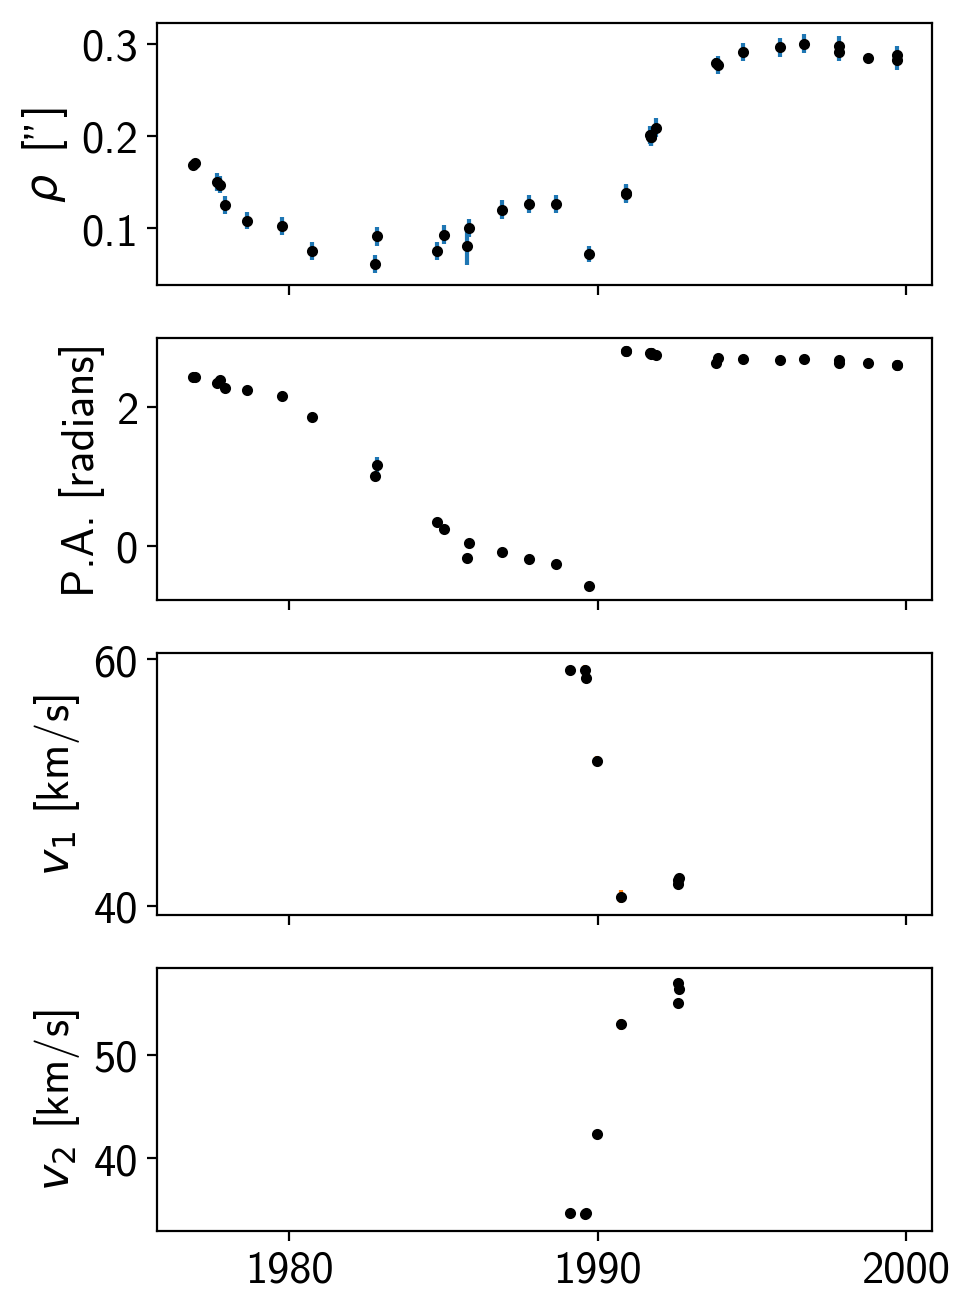

In [7]:
pkw = {"ls":"", "color":"k", "marker":"."}
ekw = {"ls":"", "color":"C1"}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(astro_yrs, rho_data, **pkw)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, **pkw)
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(rv1_yr, rv1, **pkw)
ax[2].errorbar(rv1_yr, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(rv2_yr, rv2, **pkw)
ax[3].errorbar(rv2_yr, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

In [8]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

In [9]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [10]:
au_to_km = constants.au.to(u.km).value

In [15]:
# Orbital elements from Pourbaix et al. 1998

# conversion constant
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
mparallax = 27.0 # milliarcsec 
parallax = 1e-3 * mparallax
a = a_ang / parallax # au

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * yr # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

gamma = 47.8 # km/s; systemic velocity

# kappa = a1 / (a1 + a2)
kappa = 0.45 

# calculate Mtot from a, P
Mtot = calc_Mtot(a, P)

M2 = kappa * Mtot
M1 = Mtot - M2

# n = 2 * np.pi / P
# t0 = (phi + w) / n

# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

# make a theano function to get stuff from orbit 
times = tt.vector("times")
ang = orbit.get_relative_angles(times, parallax) # the rho, theta measurements

# convert from R_sun / day to km/s
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value
    
rv1_model = conv * orbit.get_star_velocity(times)[2] + gamma
rv2_model = conv * orbit.get_planet_velocity(times)[2] + gamma

f_ang = theano.function([times], ang)
f_rv1 = theano.function([times], rv1_model)
f_rv2 = theano.function([times], rv2_model)

t = np.linspace(T0 - P, T0 + P, num=1000) # days

rho_model, theta_model = f_ang(t)

rv1s = f_rv1(t)
rv2s = f_rv2(t)

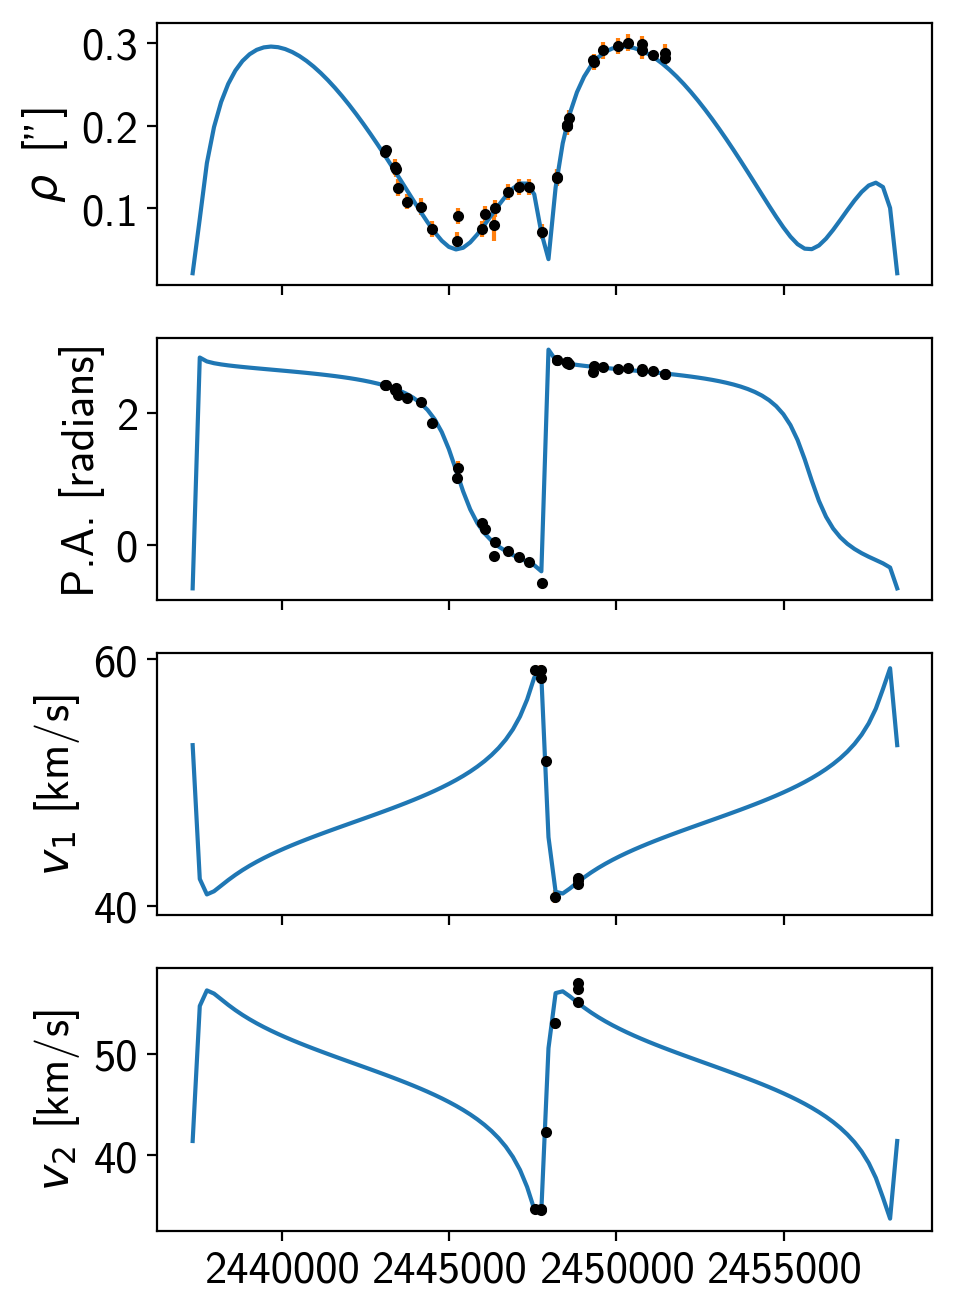

In [16]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(t, rho_model)
ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta_model)
ax[1].plot(astro_jds, theta_data, **pkw)
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(t, rv1s)
ax[2].plot(rv1_jds, rv1, **pkw)
ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(t, rv2s)
ax[3].plot(rv2_jds, rv2, **pkw)
ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

In [28]:
# Set up the model in PyMC3

# convert from R_sun / day to km/s
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)
rv_times = np.linspace(rv1_jds.min(), rv1_jds.max(), num=1000)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec 
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    M2 = pm.Normal("M2", mu=1.0, sd=0.5)
    
    gamma = pm.Normal("gamma", mu=47.8, sd=5.0) # km/s
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    
    # get the astrometric predictions
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

    # get the radial velocity predictions    
    rv1_model = conv * orbit.get_star_velocity(rv1_jds)[2] + gamma
    rv2_model = conv * orbit.get_planet_velocity(rv2_jds)[2] + gamma
    
    log_rv1_s = pm.Normal("logRV1S", mu=np.log(np.median(rv1_err)), sd=5.0)
    log_rv2_s = pm.Normal("logRV2S", mu=np.log(np.median(rv2_err)), sd=5.0)
    
    rv1_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv1_s))
    rv2_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv2_s))
    
    pm.Normal("obs_rv1", mu=rv1, observed=rv1_model, sd=rv1_tot_err)
    pm.Normal("obs_rv2", mu=rv2, observed=rv2_model, sd=rv2_tot_err)
    
    # save for future plots 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    
    
    rv1_dense = pm.Deterministic("rv1Save", conv * orbit.get_star_velocity(rv_times)[2] + gamma)
    rv2_dense = pm.Deterministic("rv2Save", conv * orbit.get_planet_velocity(rv_times)[2] + gamma)

In [22]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logRV2S', 'logRV1S', 'logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'gamma', 'M2', 'logP_interval__', 'a_ang_interval__', 'mparallax']
message: Desired error not necessarily achieved due to precision loss.
logp: -181.7563348389932 -> 171.06970010730322


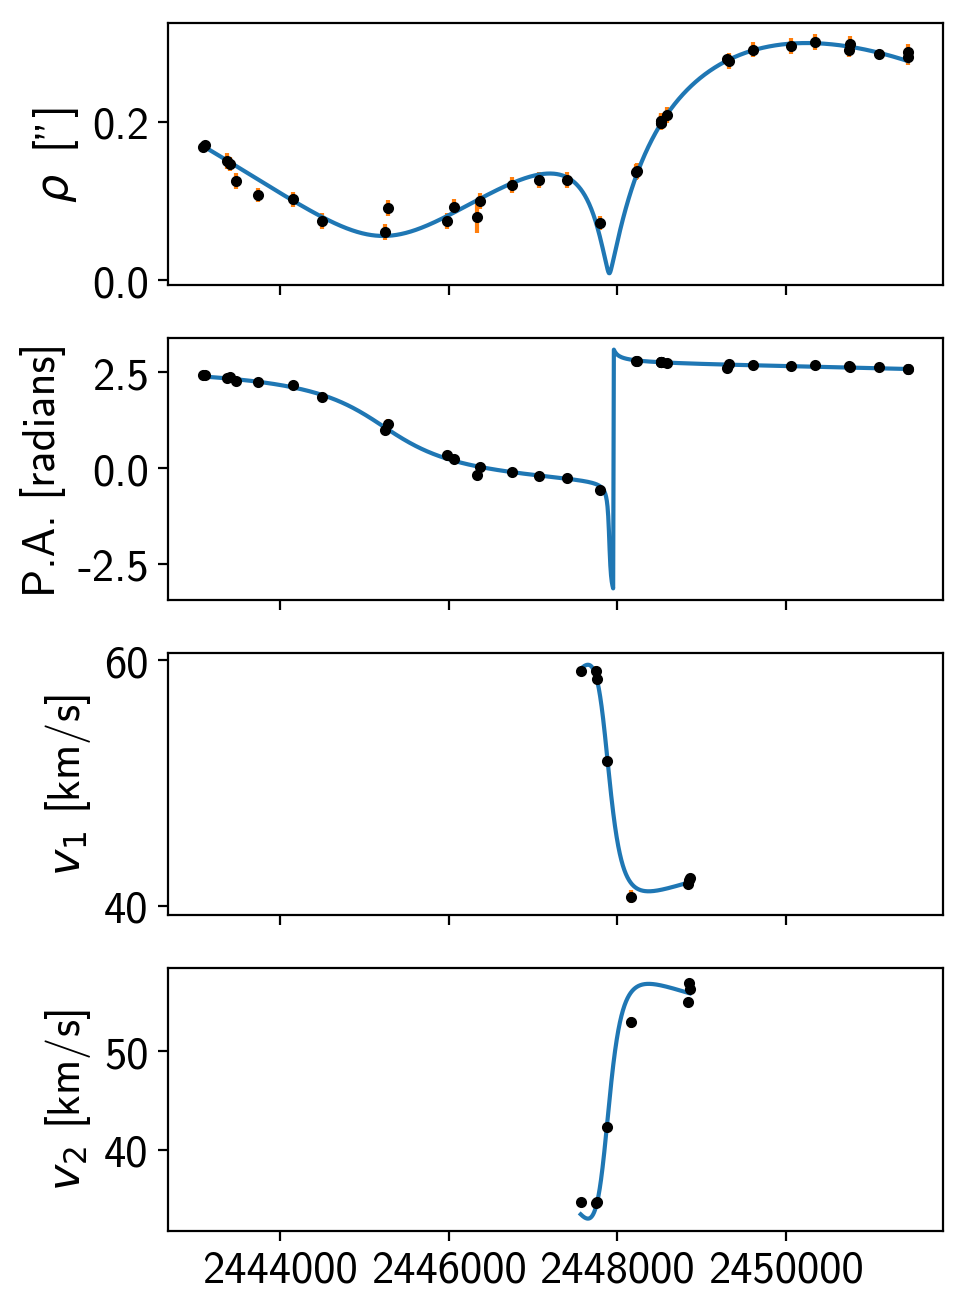

In [29]:
with model:

    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[1].plot(astro_jds, theta_data, **pkw)
    ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
    ax[1].set_ylabel(r'P.A. [radians]');

    ax[2].plot(rv_times, xo.eval_in_model(rv1_dense, map_sol))
    ax[2].plot(rv1_jds, rv1, **pkw)
    ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
    ax[2].set_ylabel(r"$v_1$ [km/s]")

    ax[3].plot(rv_times, xo.eval_in_model(rv2_dense, map_sol))
    ax[3].plot(rv2_jds, rv2, **pkw)
    ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
    ax[3].set_ylabel(r"$v_2$ [km/s]");

In [30]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=map_sol,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains: 100%|██████████| 1208/1208 [00:07<00:00, 172.37draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logRV2S, logRV1S, logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, gamma, M2, logP, a_ang, mparallax]
Sampling 4 chains: 100%|██████████| 16000/16000 [01:08<00:00, 232.10draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23c80400>,
      dtype=object)

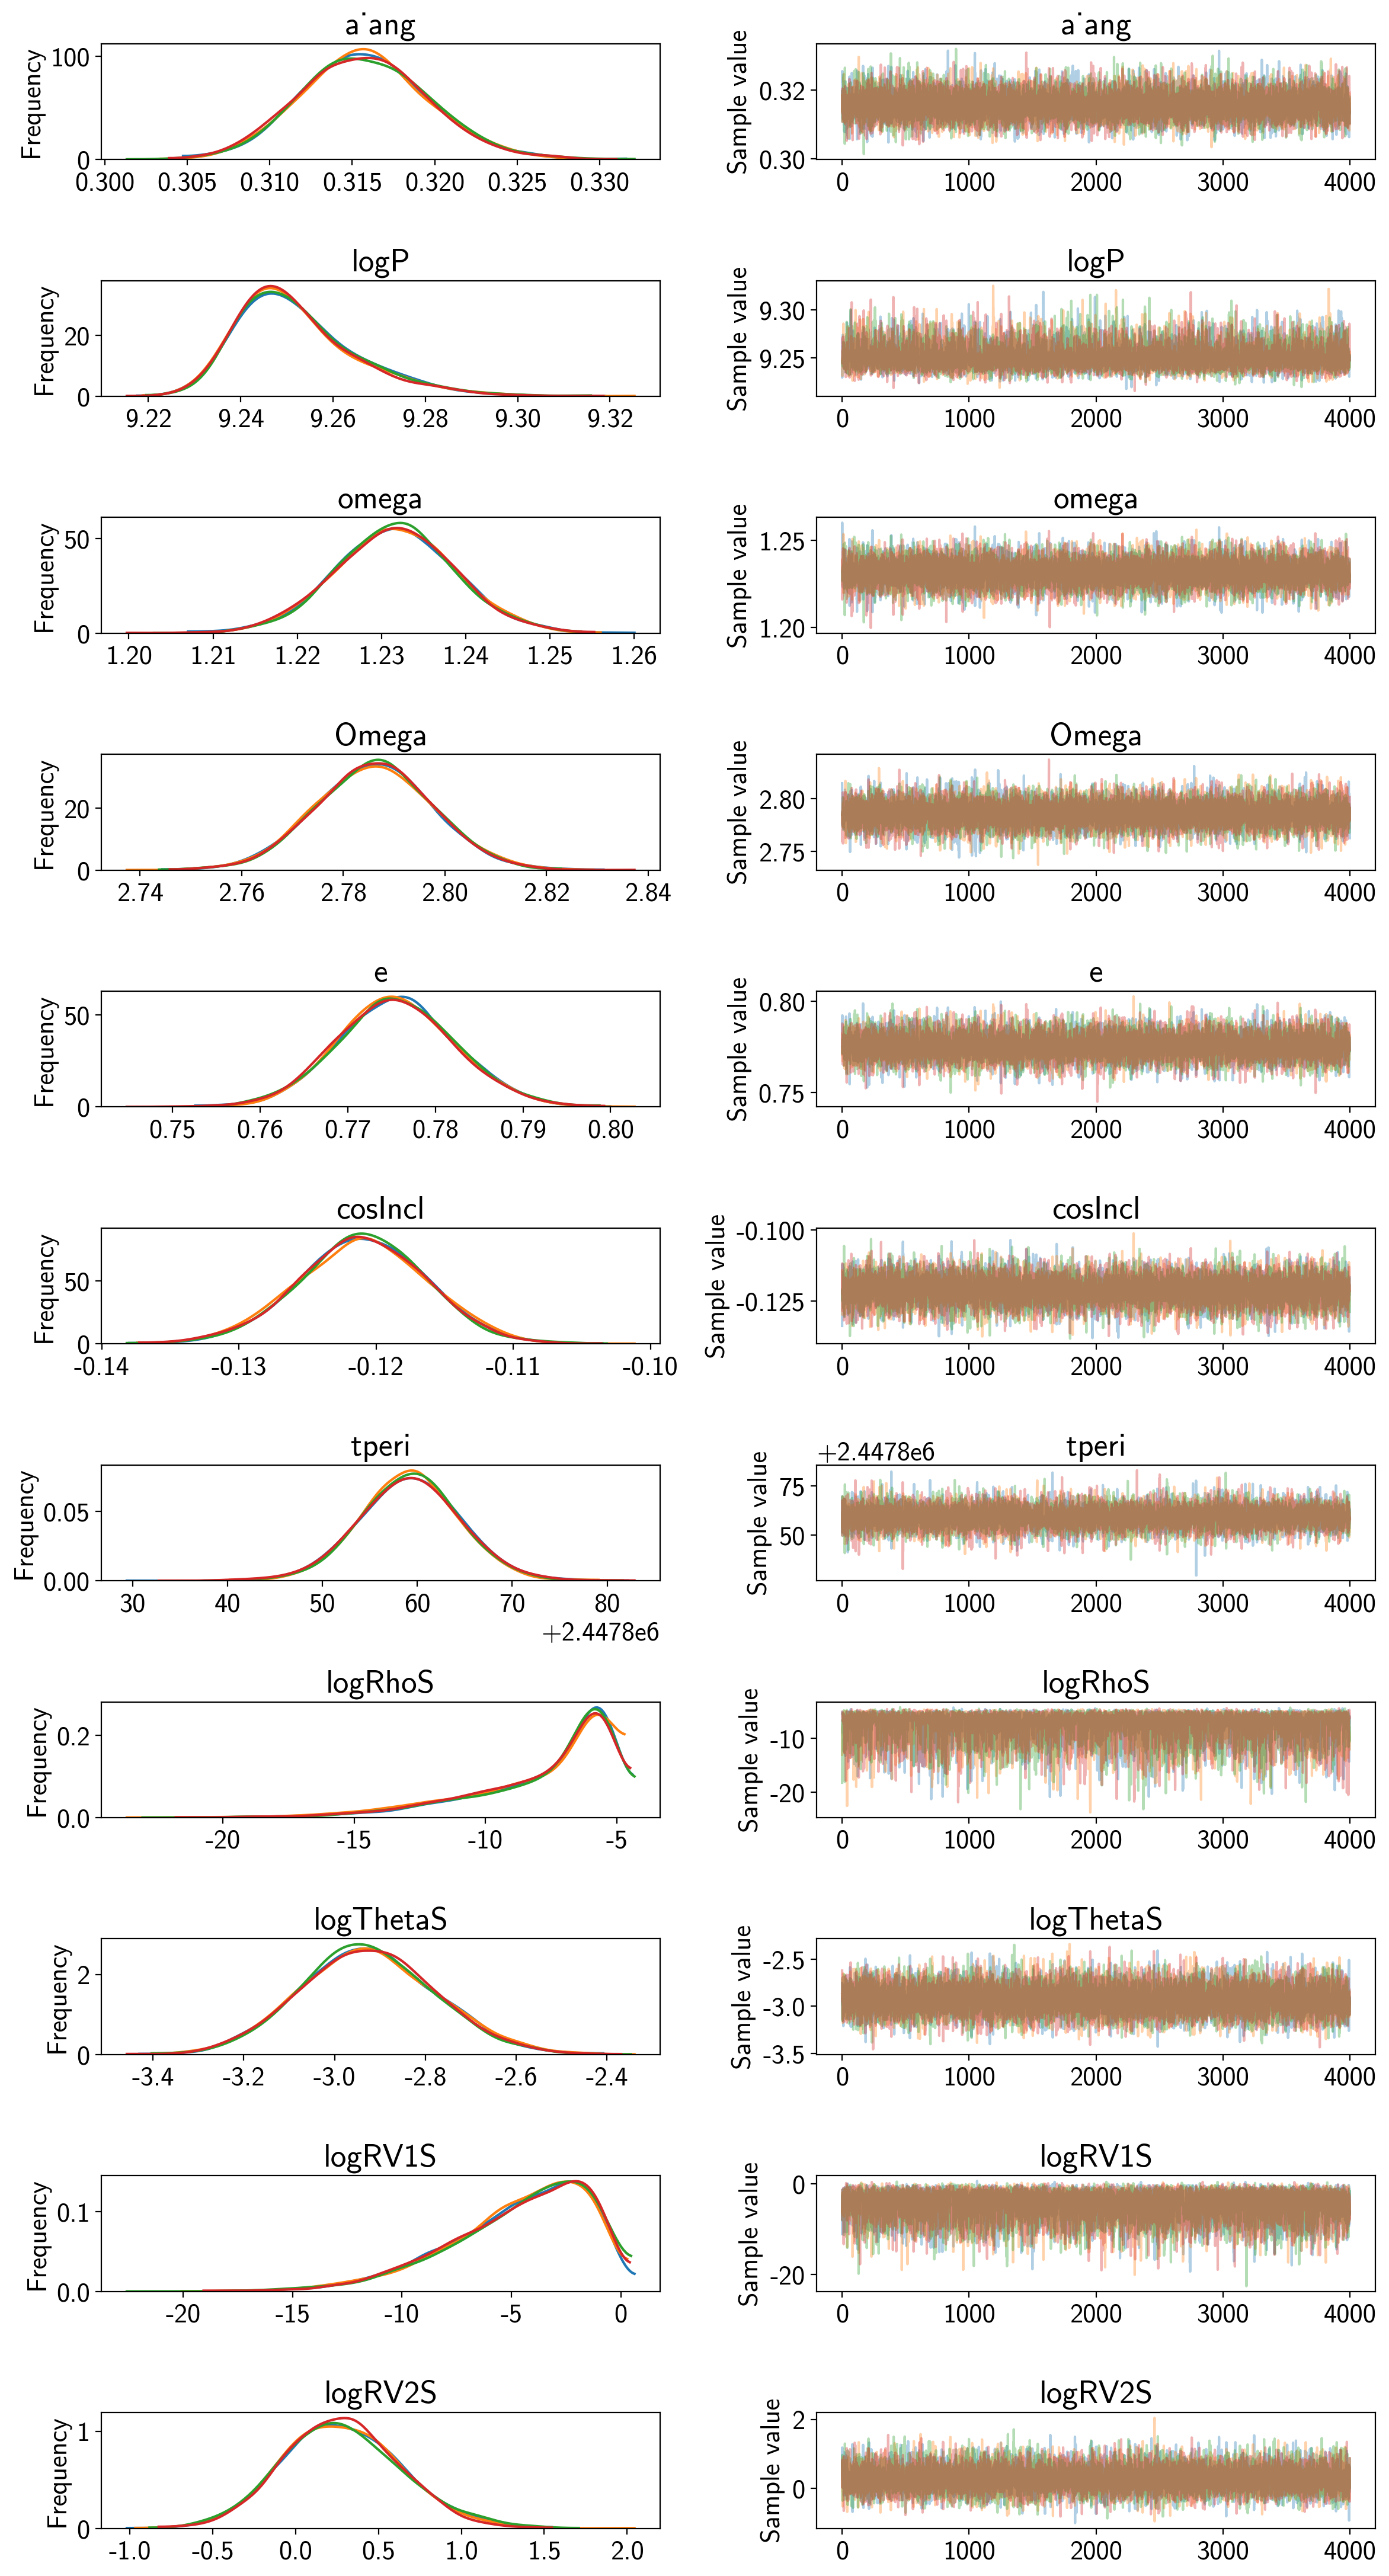

In [32]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", 
                              "logRhoS", "logThetaS", "logRV1S", "logRV2S"])

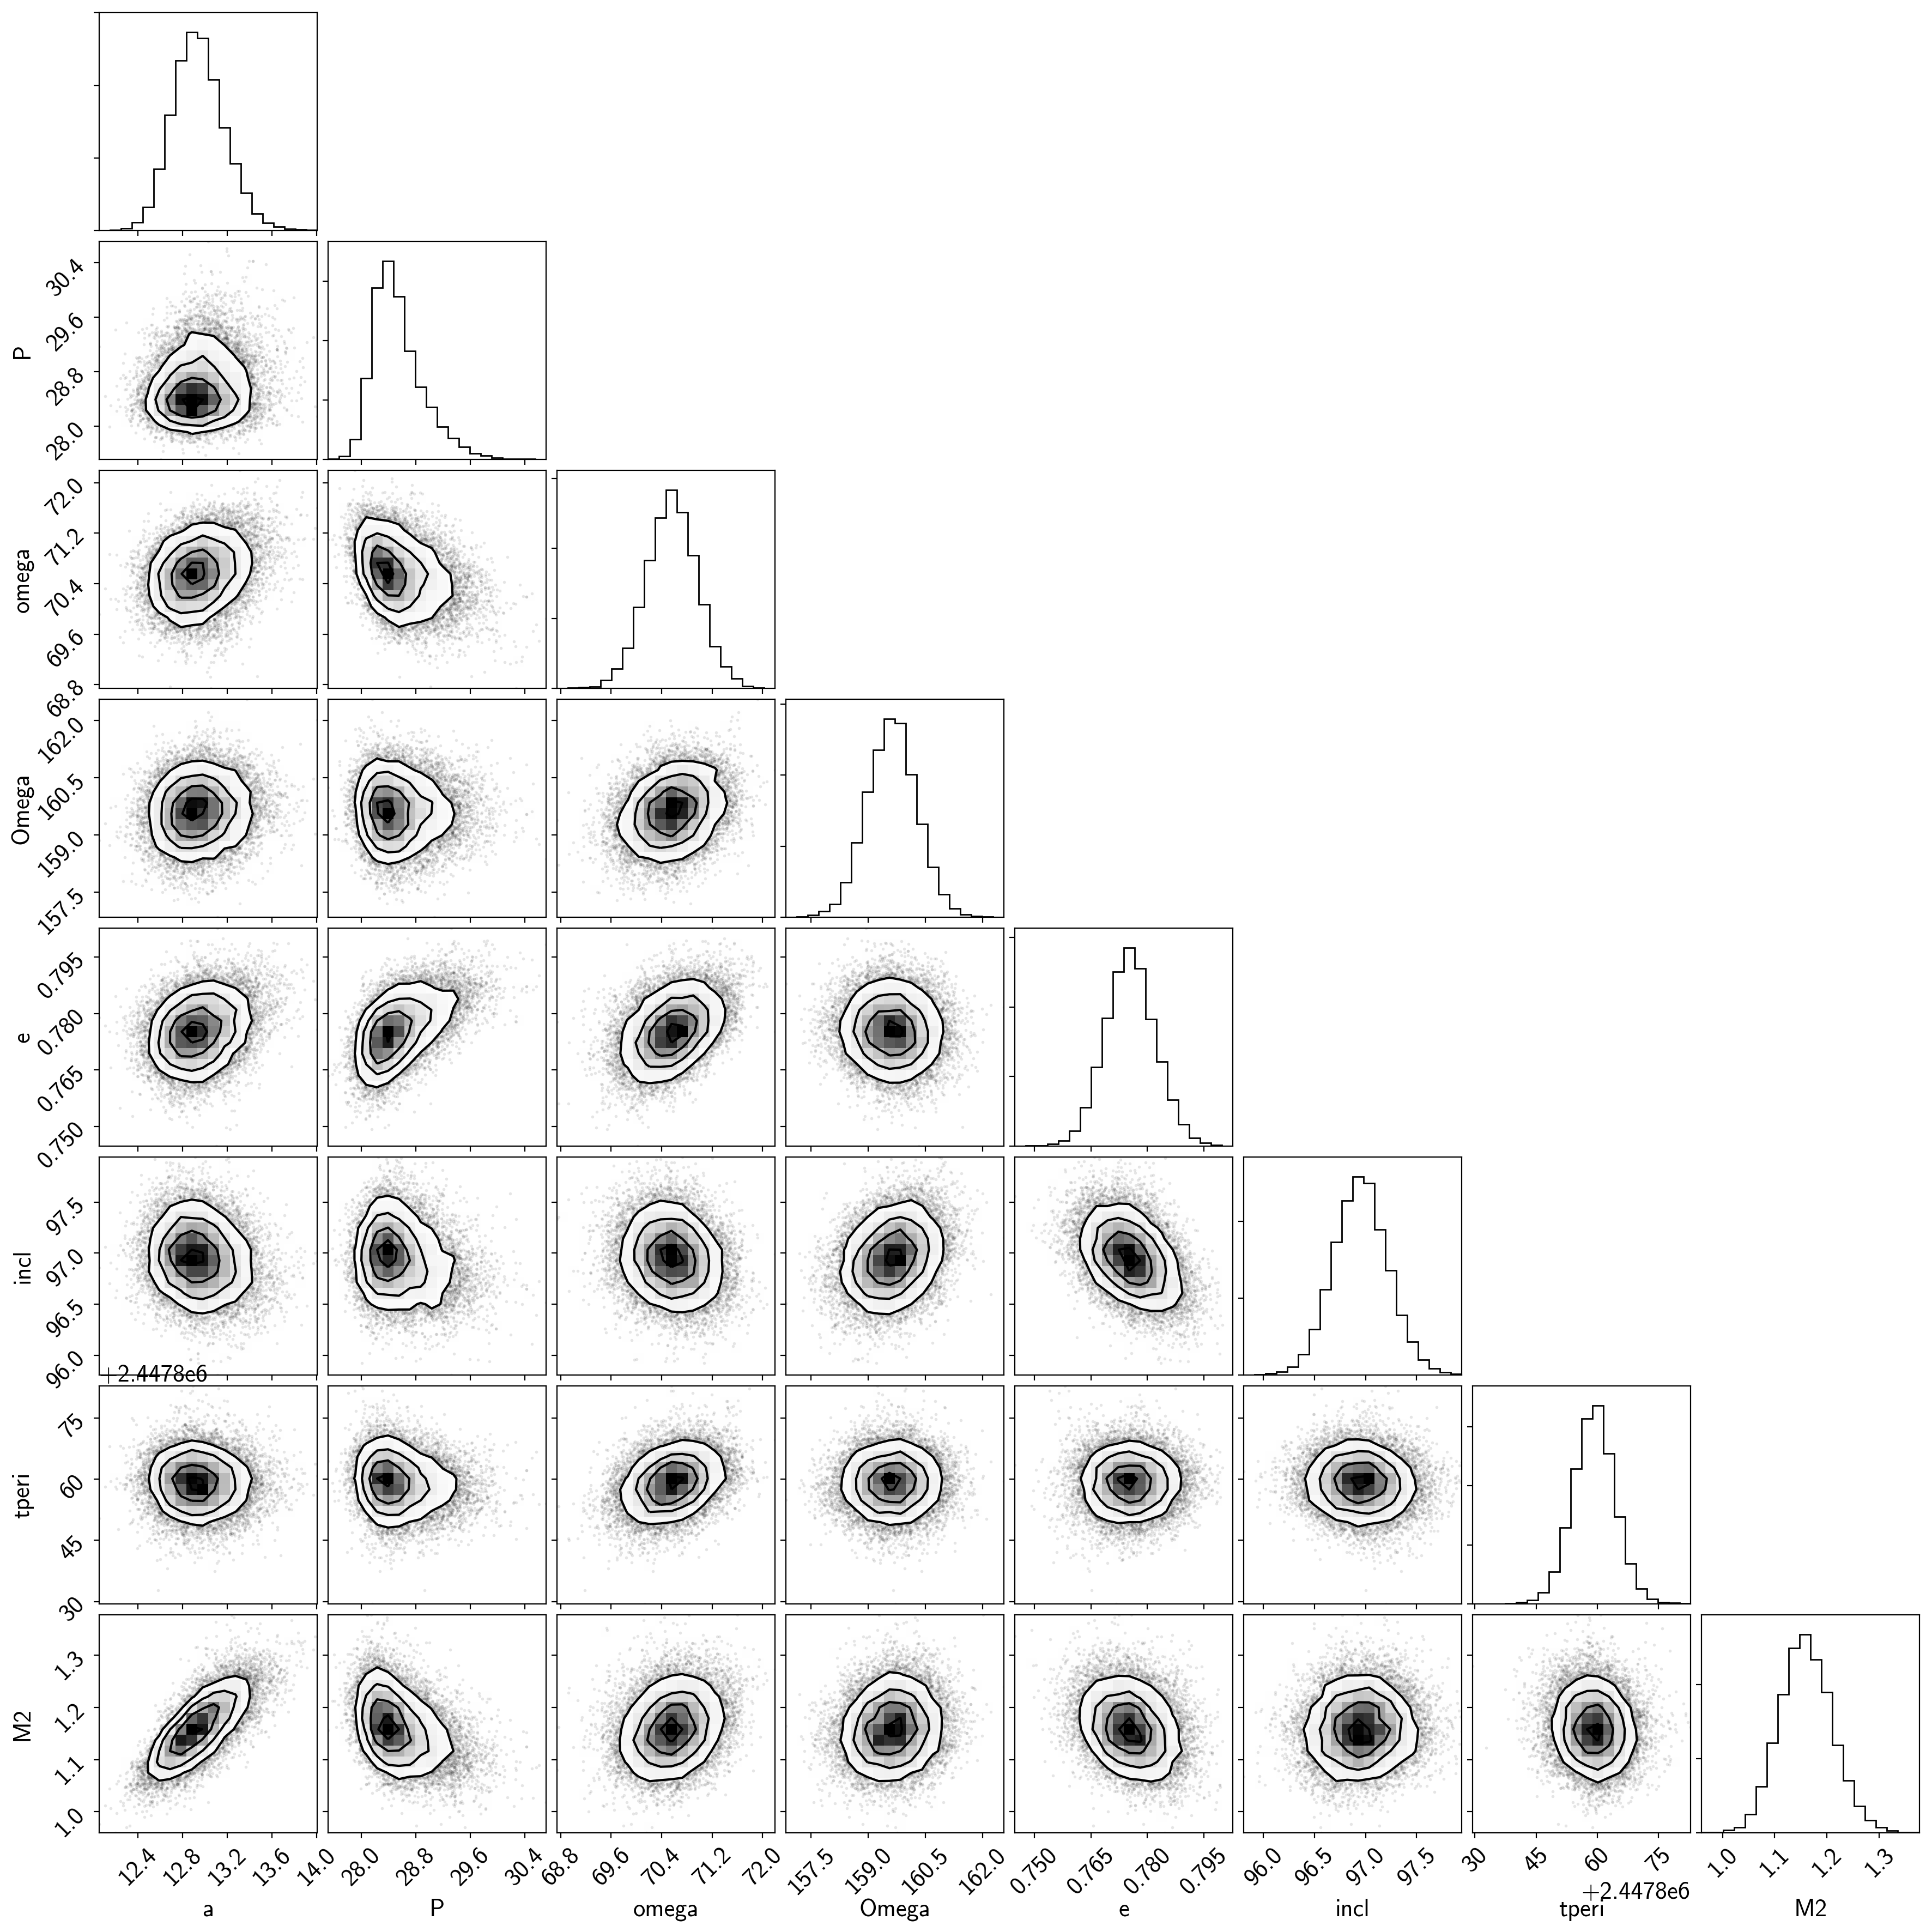

In [42]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["a", "P", "omega", "Omega", "e", "incl", "tperi", "M2"])

samples["P"] /= yr
samples["incl"] /= deg
samples["omega"] /= deg
samples["Omega"] /= deg

corner.corner(samples);

<ErrorbarContainer object of 3 artists>

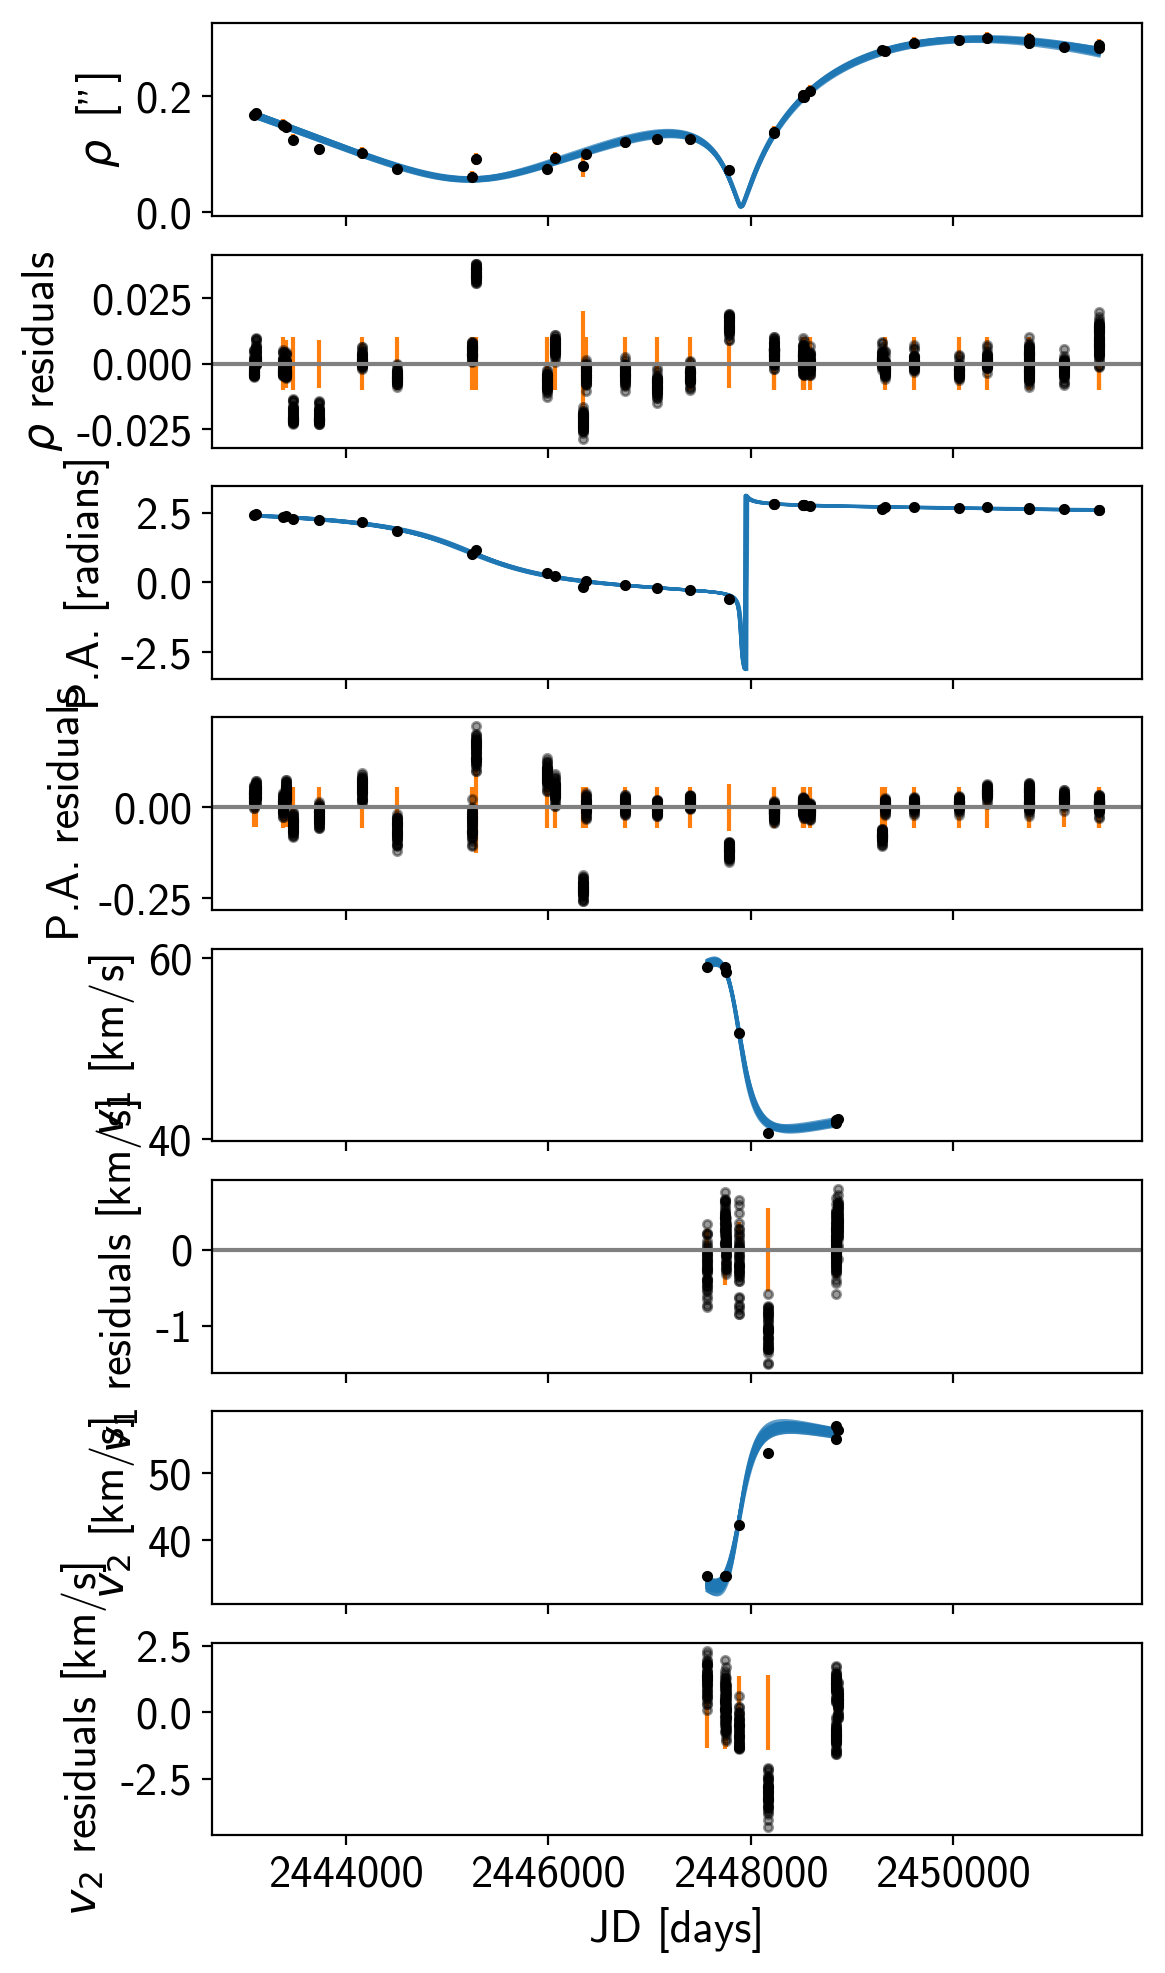

In [44]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=8, sharex=True, figsize=(6,12))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

nsamples = 50
choices = np.random.choice(len(trace), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

tot_rv1_err = np.sqrt(rv1_err**2 + np.exp(2 * np.median(trace["logRV1S"])))
tot_rv2_err = np.sqrt(rv2_err**2 + np.exp(2 * np.median(trace["logRV2S"])))
    

ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')
ax[4].set_ylabel(r'$v_1$ [km/s]')
ax[5].set_ylabel(r'$v_1$ residuals [km/s]')
ax[6].set_ylabel(r'$v_2$ [km/s]')
ax[7].set_ylabel(r'$v_2$ residuals [km/s]')
ax[7].set_xlabel("JD [days]")    


# fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))


with model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
    
#         rho_pred = pos["rhoSaveSky"]
#         theta_pred = pos["thetaSaveSky"]

#         x_pred = rho_pred * np.cos(theta_pred) # X north
#         y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(t_fine, pos["rhoSave"], color="C0", lw=0.8, alpha=0.7)
        
        ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, pos), **pkw, alpha=0.4)

        ax[2].plot(t_fine, pos["thetaSave"], color="C0", lw=0.8, alpha=0.7)

        ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, pos), **pkw, alpha=0.4)

        ax[4].plot(rv_times, pos["rv1Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[5].plot(rv1_jds, rv1 - xo.eval_in_model(rv1_model, pos), **pkw, alpha=0.4)
        
        ax[6].plot(rv_times, pos["rv2Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[7].plot(rv1_jds, rv2 - xo.eval_in_model(rv2_model, pos), **pkw, alpha=0.4)
        
#         ax_sky.plot(y_pred, x_pred, color="C0", lw=0.8, alpha=0.7)
        
        

ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_rho_err, **ekw)

ax[2].plot(astro_jds, theta_data, **pkw)
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_theta_err, **ekw) 

ax[4].plot(rv1_jds, rv1, **pkw)

ax[5].axhline(0.0, color="0.5")
ax[5].errorbar(rv1_jds, np.zeros_like(rv1_jds), yerr=tot_rv1_err, **ekw)

ax[6].plot(rv2_jds, rv2, **pkw)

ax[7].axhline(0.0, color="0.5")
ax[7].errorbar(rv2_jds, np.zeros_like(rv2_jds), yerr=tot_rv2_err, **ekw)

# ax_sky.plot(ys, xs, "ko")
# ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
# ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
# ax_sky.invert_xaxis()
# ax_sky.plot(0,0, "k*")
# ax_sky.set_aspect("equal", "datalim")